In [1]:
from dyadic_fem import *
%matplotlib notebook

## First we check our FEM solution against a known analytic solution
Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM, where $a(x)=1$ is constant, with  homogeneous Dirichlet bdry conditions and $f(x) = 1$. This is the Poisson equation and has a known analytic solution, which we check our solution against. We see that the FEM solution on the $2^8$ subdivided square has converged closer to the solution than the $2^4$ subdivided square.

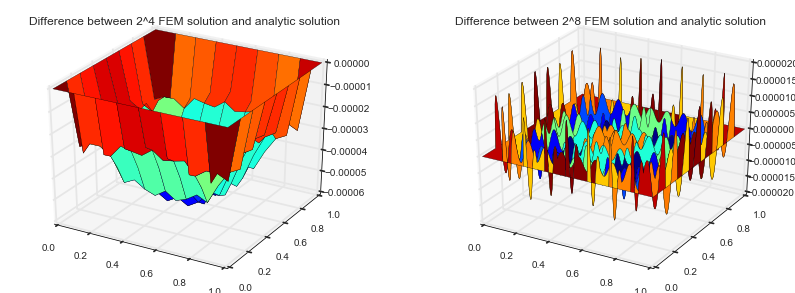

In [2]:
constant_field = ConstantField(c=1.0)

fem_coarse = DyadicFEMSolver(div=4, rand_field=constant_field, f=1.0)
fem_fine = DyadicFEMSolver(div=8, rand_field=constant_field, f=1.0)

# We make the appropriate grid for both the fine and the coarse FEM solution
x = np.linspace(0.0, 1.0, fem_coarse.n_side + 2, endpoint = True) 
xs_coarse, ys_coarse = np.meshgrid(x, x)
x = np.linspace(0.0, 1.0, fem_fine.n_side + 2, endpoint = True) 
xs_fine, ys_fine = np.meshgrid(x, x)

def analytic_soln(x,y,N=10,M=10):
    # This is the standard solution for the Poisson problem on the unit square
    soln = np.zeros(x.shape)
    for i in range(N):
        for j in range(M):
            n = 2*i+1
            m = 2*j+1
            soln = soln + (4.0 / (math.pi*math.pi*math.pi*math.pi)) * (1.0/(n*m*(n*n + m*m))) * np.sin(n*math.pi*x) * np.sin(m*math.pi*y)   
    return soln

# Solve both the FEM problems
fem_coarse.solve()
fem_fine.solve()

%matplotlib inline
# Now just plot the difference between the analytic solution and the FEM solution
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_axis_bgcolor('white')
wframe_analytic = ax.plot_surface(xs_coarse, ys_coarse, fem_coarse.u - analytic_soln(xs_coarse, ys_coarse), 
                                  cstride=2**(fem_coarse.div - 3), rstride=2**(fem_coarse.div-3), cmap=cm.jet)
ax.set_title('Difference between 2^4 FEM solution and analytic solution')

fig2 = plt.figure(1,2,2)
#ax2 = Axes3D(fig2)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_axis_bgcolor('white')
wframe_analytic_2 = ax2.plot_surface(xs_fine, ys_fine, fem_fine.u - analytic_soln(xs_fine, ys_fine), 
                                  cstride=2**(fem_fine.div - 3), rstride=2**(fem_fine.div-3), cmap=cm.jet)
ax2.set_title('Difference between 2^8 FEM solution and analytic solution')

#fem.plot()
plt.show()
%matplotlib notebook

# We trust our FEM solution is correct, now we try arbitrary dyadic fields

Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM,where $a(x)$ is a randomly generated piecewise constant function on the dyadic subdivision of the unit square

<IPython.core.display.Javascript object>


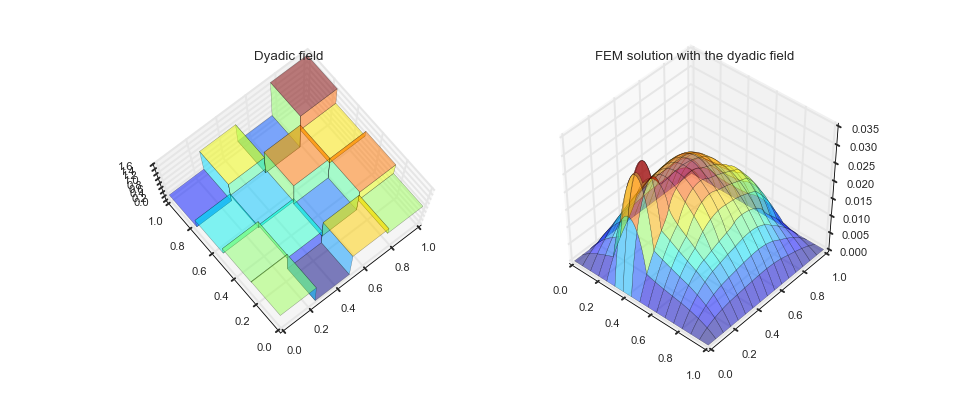

In [5]:
field = DyadicField(div=2, a_bar=1.0, c=0.99, seed=2)
fem = DyadicFEMSolver(div=6, rand_field=field, f=1.0)

fem.solve()


fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

x = np.linspace(0.0, 1.0, field.n_side+1, endpoint = True).repeat(2)[1:-1]
xs, ys = np.meshgrid(x, x)
wframe = ax.plot_surface(xs, ys, field.field.repeat(2, axis=0).repeat(2, axis=1), cstride=1, rstride=1, 
                         cmap=cm.jet, alpha=0.5)
ax.set_title('Dyadic field')
ax.set_axis_bgcolor('white')
ax = fig.add_subplot(1, 2, 2, projection='3d')


x = np.linspace(0.0, 1.0, fem.n_side + 2, endpoint = True) 
xs, ys = np.meshgrid(x, x)
div_frame = 4
wframe = ax.plot_surface(xs, ys, fem.u, cstride=2**(fem.div - div_frame), rstride=2**(fem.div-div_frame), 
                         cmap=cm.jet, alpha=0.5)
ax.set_axis_bgcolor('white')
ax.set_title('FEM solution with the dyadic field')

#field.plot()
#fem.plot()

plt.show()